# Мутировавшая домашка

Давайте попробуем построить модель, которая могла бы ответить на вопрос "А поставит ли человек лайк в паблик?". Возможно, что здесь нас ждёт успех.

In [1]:
import pandas as pd               
import numpy as np                
import matplotlib.pyplot as plt   
import matplotlib
import seaborn as sns              
plt.style.use('ggplot')
from sklearn.metrics import *
import itertools
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
np.random.seed(42)

In [2]:
# Функция для отрисовки roc-auc кривой    
def roc_auc_pic(y_hat_test, y_test):    
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_hat_test)
    roc_auc_test = roc_auc_score(y_test, y_hat_test)

    matplotlib.rcParams['figure.figsize'] = (8, 8)
    plt.plot(fpr_test, tpr_test, label='Test ROC AUC {0}'.format(roc_auc_test))
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show() 
    pass

In [3]:
df = pd.read_csv('vk_main.csv', sep='\t')   # подгружаем датасет
df.head()

,city,country,first_name,home_town,last_name,likes_memes,uid,male_dummy,facebook_dummy,instagram_dummy,...,photo_month_mean,photo_repost_cnt,photo_repost_max,photo_repost_mean,photo_repost_median,photo_text_len_cnt,photo_ava_change_cnt,photo_text_url_len_cnt,friends_from_course_cnt,friends_mail_from_course_pct
0,Москва,Россия,Артём,MOSCOW,Еркин,0,181029517,1,0,0,...,1.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,16.0,0.375000
1,NaN,Россия,Армен,NaN,Хачатрян,15,73703994,1,0,1,...,1.750000,4.0,1.0,0.571429,1.0,0.0,0.0,0.0,47.0,0.531915
2,Москва,Россия,Abbos,Бекабад,Akhmedov,11,467673028,1,0,0,...,1.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,26.0,0.500000
3,Москва,Россия,Адам,NaN,Триандафилиди,0,144910934,1,0,1,...,1.428571,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,83.0,0.518072
4,Алматы,Казахстан,Айжан,NaN,Саят,9,166045266,0,0,0,...,1.333333,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,29.0,0.344828


In [4]:
# Наш таргет: "а он лайкнул мем хотя бы раз?"
df['ln_likes_memes'] = df['likes_memes'] > 0

In [5]:
# выбрасываем из выборки все переменные, в которых слишком много пропусков
isnull = df.isnull().sum()
df = df[isnull[isnull <= 56].index]

# Выборка с переменными-счётчиками
variables_cnt = [item for item in df.columns if item[-3:] == 'cnt']

# Оставляем только информативные переменные
variables_cnt = [item for item in variables_cnt if len(df[item].unique()) > 10]

# логарифмируем счётчики
df[variables_cnt] = df[variables_cnt].apply(lambda w: np.log(w + 1))

# отбираем дамми - переменные 
variables_dummy = [item for item in df.columns if item[-5:] == 'dummy']

# средние, медианы и максимумы
variables_mean = [item for item in df.columns if item[-4:] == 'mean']
variables_median = [item for item in df.columns if item[-6:] == 'median']
variables_max = [item for item in df.columns if item[-3:] == 'max']

# все полезные переменные
useful_variables = variables_cnt + variables_dummy + variables_mean + \
                   variables_median + variables_max + ['friends_mail_from_course_pct']

# заполняем пропуски нулями
df[useful_variables] = df[useful_variables].fillna(0)
df.head()

,country,first_name,last_name,likes_memes,uid,male_dummy,facebook_dummy,instagram_dummy,skype_dummy,twitter_dummy,...,photo_repost_cnt,photo_repost_max,photo_repost_mean,photo_repost_median,photo_text_len_cnt,photo_ava_change_cnt,photo_text_url_len_cnt,friends_from_course_cnt,friends_mail_from_course_pct,ln_likes_memes
0,Россия,Артём,Еркин,0,181029517,1,0,0,0,0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,2.833213,0.375000,False
1,Россия,Армен,Хачатрян,15,73703994,1,0,1,0,0,...,1.609438,1.0,0.571429,1.0,0.0,0.0,0.0,3.871201,0.531915,True
2,Россия,Abbos,Akhmedov,11,467673028,1,0,0,0,0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,3.295837,0.500000,True
3,Россия,Адам,Триандафилиди,0,144910934,1,0,1,1,0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,4.430817,0.518072,False
4,Казахстан,Айжан,Саят,9,166045266,0,0,0,0,0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,3.401197,0.344828,True


# 2. Подготовка к моделированию.
здесь уже начинается мой код

In [6]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size = 0.2, random_state=201905)

In [7]:
y_train = df_train['ln_likes_memes'].get_values()
y_test = df_test['ln_likes_memes'].get_values()

In [8]:
# Забираем в выборку лучших из лучших 
X_train = df_train[useful_variables].get_values()
X_test = df_test[useful_variables].get_values()

# 3. KNN, метод ближайшего соседа

In [9]:
#Нормировка
from sklearn.preprocessing import MinMaxScaler  
scaler = MinMaxScaler( )
scaler.fit(X_train) 
X_train_norm = scaler.transform(X_train) 
X_test_norm = scaler.transform(X_test)

In [10]:
from sklearn.neighbors import KNeighborsClassifier

# объявляем метод 9 ближайших соседей
knn = KNeighborsClassifier(n_neighbors = 9)

# обучаем его по выборке 
knn.fit(X_train_norm, y_train)

# строим для тестовой выборки прогнозы 
y_predict = knn.predict(X_test_norm)

Построим для получившегося алгоритма roc-кривую на тестовой выборке. 

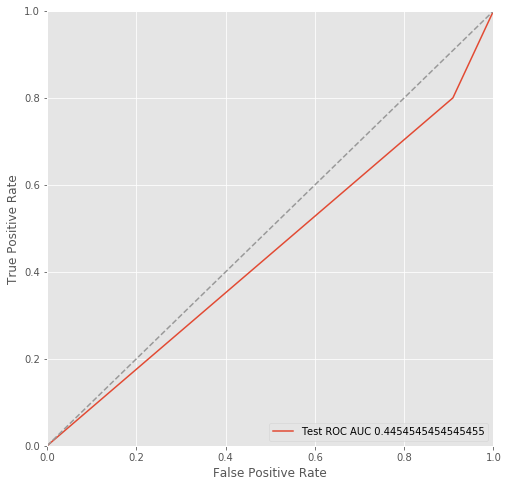

In [11]:
roc_auc_pic(y_predict, y_test)

In [12]:
accuracy_score(y_test, y_predict)

0.5671641791044776

# 4. Дерево 

In [13]:
# Подгружаем дерево 
from sklearn.tree import DecisionTreeClassifier

# Объявляем дерево 
tree = DecisionTreeClassifier( )

# учим дерево 
tree.fit(X_train_norm, y_train)

# предсказываем на тестовой выборке результаты 
y_predicted = tree.predict(X_test_norm)

# посчитали долю верных ответов
print('accuracy:', accuracy_score(y_test, y_predicted))
print('roc_auc:', roc_auc_score(y_test, y_predicted))

accuracy: 0.582089552238806
roc_auc: 0.5262626262626263


# 5. Случайный лес 

In [14]:
# Подгружаем случайный лес
from sklearn.ensemble import RandomForestClassifier

# объявляем его, будем учить 1000 деревьев
forest = RandomForestClassifier(n_estimators=1000)

# учим лес 
forest.fit(X_train_norm, y_train)

# строим предсказания 
y_predicted = forest.predict(X_test_norm)

# посчитали долю верных ответов
print('accuracy:', accuracy_score(y_test, y_predicted))
print('roc_auc:', roc_auc_score(y_test, y_predicted))

accuracy: 0.582089552238806
roc_auc: 0.4797979797979798


# 7. SVM

In [15]:
from sklearn.svm import SVC
svm = SVC(random_state = 1)
svm.fit(X_train_norm, y_train)
print('accuracy:', svm.score(X_test_norm, y_test))

accuracy: 0.6716417910447762


# 8. Гаусс

In [16]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train_norm, y_train)
print("accuracy:", nb.score(X_test_norm, y_test))

accuracy: 0.5671641791044776


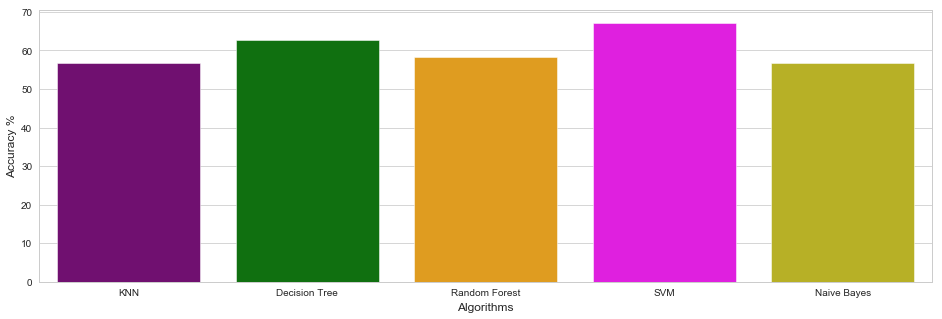

In [17]:
methods = ["KNN", "Decision Tree", "Random Forest", "SVM", "Naive Bayes"]
accuracy = [56.7, 62.7, 58.2, 67.16, 56.72]
colors = ["purple", "green", "orange", "magenta","#CFC60E","#0FBBAE"]

sns.set_style("whitegrid")
plt.figure(figsize=(16,5))
plt.yticks(np.arange(0,100,10))
plt.ylabel("Accuracy %")
plt.xlabel("Algorithms")
sns.barplot(x=methods, y=accuracy, palette=colors)
plt.show()

### А теперь попробуем запустить несколько алгоритмов (KNN, DT, RF), только с перебором параметров с помощью случайного поиска. Ах да, проблема низкого скора наверное заключалась в метрике. Сменим ее на F-меру

In [18]:
from sklearn.model_selection import GridSearchCV

# параметры, которые мы будем перебирать 
parameters = {
     'n_neighbors':range(5, 15),         
     'weights':['uniform', 'distance']
             }

knn_clf = KNeighborsClassifier()


grid_knn = GridSearchCV(knn_clf, parameters, cv=15, scoring="f1")
grid_knn.fit(X_train_norm, y_train)
print(grid_knn.best_params_)
print(grid_knn.best_score_)

{'n_neighbors': 14, 'weights': 'distance'}
0.7393230711835962


In [19]:
tree = DecisionTreeClassifier( )
# параметры, которые мы будем перебирать 
parameters = {
     'max_depth':range(3, 15),         
     'criterion':['gini', 'entropy']
             }


grid_tree = GridSearchCV(tree, parameters, cv=16, scoring="f1")
grid_tree.fit(X_train_norm, y_train)
print(grid_tree.best_params_)
print(grid_tree.best_score_)

{'criterion': 'gini', 'max_depth': 4}
0.7573622375893629


In [20]:
forest = RandomForestClassifier()
parameters = {'n_estimators':range(680, 687, 1)}
grid_forest = GridSearchCV(forest, parameters, cv=10, scoring="f1")
grid_forest.fit(X_train, y_train)
print(grid_forest.best_params_)
print(grid_forest.best_score_)

{'n_estimators': 680}
0.7447597249122356


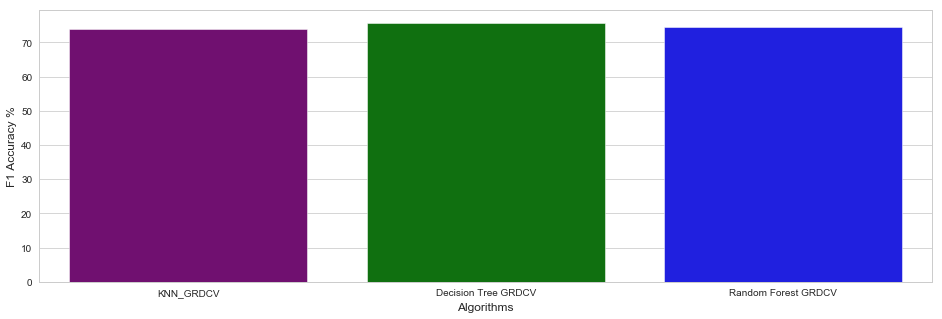

In [21]:
methods = ["KNN_GRDCV", "Decision Tree GRDCV", "Random Forest GRDCV"]
accuracy = [73.9, 75.7, 74.4]
colors = ["purple", "green","blue"]

sns.set_style("whitegrid")
plt.figure(figsize=(16,5))
plt.yticks(np.arange(0,100,10))
plt.ylabel("F1 Accuracy %")
plt.xlabel("Algorithms")
sns.barplot(x=methods, y=accuracy, palette=colors)
plt.show()